In [1]:
import pandas as pd
star_standard = pd.read_csv("Data/Stationary/RTT_Standard.csv")
star_mobile = pd.read_csv("Data/Stationary/RTT_Roam.csv")
star_fhp = pd.read_csv("Data/Stationary/RTT_FHP.csv")
autobahn = pd.read_csv("Data/Autobahn/RTT_Loss.csv")
star_standard["timestamp"] = pd.to_datetime(star_standard["timestamp"], unit="s")
star_mobile["timestamp"] = pd.to_datetime(star_mobile["timestamp"], unit="s")
star_fhp["timestamp"] = pd.to_datetime(star_fhp["timestamp"], unit="s")
autobahn["timestamp"] = pd.to_datetime(autobahn["timestamp"])


In [2]:
def split_repetitions(df):
    repetitions = []
    for rep in range(df["repetition"].max()+1):
        temp_df = df[df["repetition"] == rep]
        temp_df["lost"] = False
        repetitions.append(temp_df)
    return repetitions

standard_repetitions = split_repetitions(star_standard)
mobile_repetitions = split_repetitions(star_mobile)
fhp_repetitions = split_repetitions(star_fhp)


/tmp/ipykernel_63905/4155424744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["lost"] = False
/tmp/ipykernel_63905/4155424744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["lost"] = False
/tmp/ipykernel_63905/4155424744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [3]:
import numpy as np
def create_df_with_loss(df):
    max_seq = df["icmp_seq"].max()
    min_seq = 1
    df_with_loss = pd.DataFrame(columns=['link_name', 'repetition', 'timestamp', 'icmp_seq', 'ttl', 'time_ms', 'lost'])
    

    missing_seqs = sorted(set(range(min_seq, max_seq + 1)) - set(df['icmp_seq']))
    missing_rows = []
    for missing_seq in missing_seqs:
        missing_rows.append({
            'timestamp': np.nan,
            'icmp_seq': missing_seq,
            'ttl': 64,
            'time_ms': np.nan,
            'lost': True,
            'repetition': df["repetition"].iloc[0],
            'link_name': df["link_name"].iloc[0]
        })
    df_missing = pd.DataFrame(missing_rows)
    #print(df_missing)
    df_combined = pd.concat([df, df_missing], ignore_index=True)
    df_combined.sort_values(by='icmp_seq', inplace=True)
    df_combined.reset_index(drop=True, inplace=True)
    # Interpolate missing values in 'timestamp' column
    df_combined['timestamp'] = df_combined['timestamp'].interpolate(method='linear')
    df_with_loss = pd.concat([df_with_loss, df_combined], ignore_index=True)
    df_with_loss.reset_index(drop=True, inplace=True)
    return df_with_loss
    
standard_repetitions_loss = []
mobile_repetitions_loss = []
fhp_repetitions_loss = []
for rep in standard_repetitions:
    standard_repetitions_loss.append(create_df_with_loss(rep))
for rep in mobile_repetitions:
    mobile_repetitions_loss.append(create_df_with_loss(rep))
for rep in fhp_repetitions:
    fhp_repetitions_loss.append(create_df_with_loss(rep))

In [4]:
# merge loss dataframes
star_standard_loss = pd.concat(standard_repetitions_loss, ignore_index=True)
star_mobile_loss = pd.concat(mobile_repetitions_loss, ignore_index=True)
star_fhp_loss = pd.concat(fhp_repetitions_loss, ignore_index=True)
#len(mobile_repetitions_loss)
#star_fhp_loss.to_csv("data/star_fhp_rtt_loss.csv")
    

In [5]:
plr_standard = star_standard_loss[star_standard_loss["lost"] == True].shape[0] / star_standard_loss.shape[0] * 100
plr_mobile = star_mobile_loss[star_mobile_loss["lost"] == True].shape[0] / star_mobile_loss.shape[0] * 100
plr_fhp = star_fhp_loss[star_fhp_loss["lost"] == True].shape[0] / star_fhp_loss.shape[0] * 100
plt_autobahn = autobahn[autobahn["lost"] == True].shape[0] / autobahn.shape[0] * 100
print("PLR Standard:", plr_standard, "PLR Mobile:", plr_mobile, "PLR FHP:", plr_fhp, "Autobahn:", plt_autobahn)

PLR Standard: 0.3572929438967067 PLR Mobile: 0.4126065733754051 PLR FHP: 0.34706021629677086 Autobahn: 2.843697939009851


In [6]:
def get_burst_df(df):    
    # Identify the bursts by calculating the difference between consecutive 'lost' values
    df['shifted_lost'] = df['lost'].shift(1).fillna(False)
    df['burst_start'] = df['lost'] & ~df['shifted_lost']
    df['burst_end'] = ~df['lost'] & df['shifted_lost']
    
    # Create a "burst_id" column to uniquely identify bursts
    df['burst_id'] = df['burst_start'].cumsum()
    
    # Filter out non-burst rows and group by 'burst_id'
    bursts = df[df['lost']].groupby('burst_id').agg(
        burst_length=('lost', 'size'),
        starttime=('timestamp', 'first'),
        endtime=('timestamp', 'last')
    ).reset_index()
    
    # Only consider valid bursts (ignore burst_id == 0 which corresponds to no burst)
    bursts = bursts[bursts['burst_id'] != 0]
    
    return bursts[['burst_length', 'starttime', 'endtime']]

standard_burst_lengths = pd.DataFrame(columns=['burst_length', 'starttime', 'endtime'])
mobile_burst_lengths = pd.DataFrame(columns=['burst_length', 'starttime', 'endtime'])
fhp_burst_lengths = pd.DataFrame(columns=['burst_length', 'starttime', 'endtime'])
autobahn_burst_lengths = pd.DataFrame(columns=['burst_length', 'starttime', 'endtime'])

# standard_burst_lengths = []
# mobile_burst_lengths = []
# fhp_burst_lengths = []

for rep in standard_repetitions_loss:
    bursts = get_burst_df(rep)
    standard_burst_lengths = pd.concat([standard_burst_lengths, bursts], ignore_index=True)
    # standard_burst_lengths.append(bursts)
for rep in mobile_repetitions_loss:
    bursts = get_burst_df(rep)
    mobile_burst_lengths = pd.concat([mobile_burst_lengths, bursts], ignore_index=True)
    # mobile_burst_lengths.append(bursts)
for rep in fhp_repetitions_loss:
    bursts = get_burst_df(rep)
    fhp_burst_lengths = pd.concat([fhp_burst_lengths, bursts], ignore_index=True)
    # fhp_burst_lengths.append(bursts)
autobahn_burst_lengths = get_burst_df(autobahn)

print("Standard:", standard_burst_lengths["burst_length"].mean())
print("Mobile:", mobile_burst_lengths["burst_length"].mean())
print("FHP:", fhp_burst_lengths["burst_length"].mean())
print("Autobahn:", autobahn_burst_lengths["burst_length"].mean())

Standard: 1.9699642431466031
Mobile: 1.9945389624028564
FHP: 2.120180802977931
Autobahn: 11.31413612565445


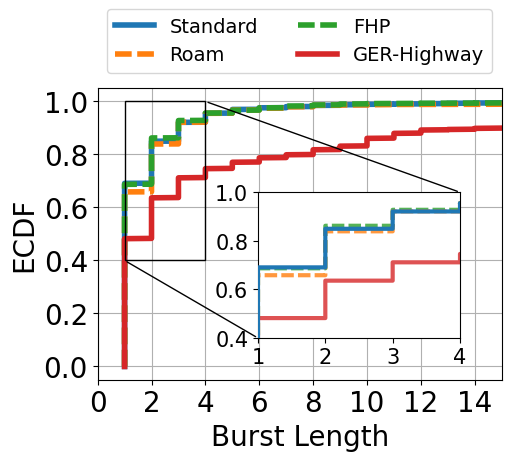

In [7]:
"""Fig 6d - plot CDF burst loss"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

standard_burst_sorted = np.sort(standard_burst_lengths["burst_length"]) # ein ausreißer mit 482
mobile_burst_sorted = np.sort(mobile_burst_lengths["burst_length"])
fhp_burst_sorted = np.sort(fhp_burst_lengths["burst_length"]) # ein ausreißer mit 1086
autobahn_burst_sorted = np.sort(autobahn_burst_lengths["burst_length"])

y_values_standard = np.arange(len(standard_burst_sorted)-1) / float(len(standard_burst_sorted) - 2) # ein ausreißer mit 482
y_values_mobile = np.arange(len(mobile_burst_sorted)) / float(len(mobile_burst_sorted) - 1)
y_values_fhp = np.arange(len(fhp_burst_sorted)-1) / float(len(fhp_burst_sorted) - 2) # ein ausreißer mit 1086
y_values_autobahn = np.arange(len(autobahn_burst_sorted)) / float(len(autobahn_burst_sorted) - 1)

# Plot the CDF
# Define dash pattern
dash_pattern = [3, 1]

fig, ax = plt.subplots(figsize=(5, 4.5),constrained_layout=True)
lwidth = 4
ax.plot(standard_burst_sorted[:-1], y_values_standard, linewidth=lwidth, linestyle='-', label="Standard")
ax.plot(mobile_burst_sorted, y_values_mobile, linewidth=lwidth, linestyle=(0, dash_pattern), label="Roam")
ax.plot(fhp_burst_sorted[:-1], y_values_fhp, linewidth=lwidth, linestyle=(0, dash_pattern), label="FHP")
ax.plot(autobahn_burst_sorted, y_values_autobahn, linewidth=lwidth, label="GER-Highway")



# Place legend on top of the plot
plt.legend(prop={'size': 14}, loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2, mode='expand')
#plt.legend(prop={'size': 20}, loc="lower right")
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
x_ticks = [0, 2, 4, 6, 8, 10, 12, 14]
plt.xlim(0, 15)
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
fzsize = 20
plt.tick_params(axis='y', labelsize=fzsize)
plt.tick_params(axis='x', labelsize=fzsize)
plt.xlabel('Burst Length', size=fzsize)
plt.ylabel('ECDF', size=fzsize)
#plt.title('Cumulative Distribution Function')
plt.grid(True)
# Highlight the inset range with a rectangle
highlight_rect = patches.Rectangle((1, 0.4), 3, 0.6, linewidth=1, edgecolor='black', facecolor='none', linestyle='-', zorder=4)
ax.add_patch(highlight_rect)
# Inset with zoomed region
ax_inset = inset_axes(ax, width="50%", height="50%", loc='lower right', borderpad=3)
ax_inset.plot(standard_burst_sorted[:-1], y_values_standard, linewidth=3, linestyle='-', drawstyle='steps-post', zorder=4)
ax_inset.plot(mobile_burst_sorted, y_values_mobile, linewidth=3, linestyle=(0, dash_pattern), drawstyle='steps-post', zorder=3, alpha=0.8)
ax_inset.plot(fhp_burst_sorted[:-1], y_values_fhp, linewidth=3, linestyle=(0, dash_pattern), drawstyle='steps-post', zorder=2, alpha=0.8)
ax_inset.plot(autobahn_burst_sorted, y_values_autobahn, linewidth=3, linestyle='-', drawstyle='steps-post', zorder=1, alpha=0.8)

ax_inset.set_xlim(1, 4)
ax_inset.set_ylim(0.4, 1)
ax_inset.yticks = [0.4, 0.6, 0.8, 1.0]

# Set inset tick label size
inset_tick_label_size = 15
ax_inset.tick_params(axis='x', labelsize=inset_tick_label_size)
ax_inset.tick_params(axis='y', labelsize=inset_tick_label_size)

# Add a line from (4, 1) on the main plot to the top-right corner of the inset plot
ax.annotate(
    '', xy=(4, 1), xycoords='data',
    xytext=(1, 1), textcoords=ax_inset.transAxes,
    arrowprops=dict(arrowstyle='-', color='black', lw=1, linestyle='-')
)
ax.annotate(
    '', xy=(1, 0.4), xycoords='data',
    xytext=(0, 0), textcoords=ax_inset.transAxes,
    arrowprops=dict(arrowstyle='-', color='black', lw=1)
)
#plt.tight_layout()
plt.savefig("Plots/Fig6d.pdf", format="pdf")

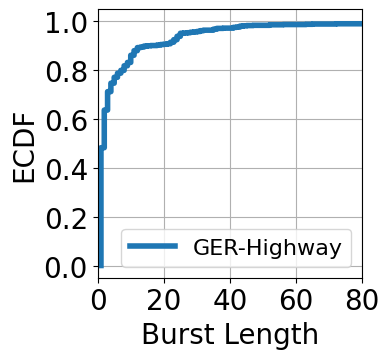

In [8]:
"""Fig. 4 - plot CDF burst loss"""
import numpy as np
import matplotlib.pyplot as plt

autobahn_burst_sorted = np.sort(autobahn_burst_lengths["burst_length"])
y_values_autobahn = np.arange(len(autobahn_burst_sorted)) / float(len(autobahn_burst_sorted) - 1)

# Plot the CDF
fig, ax = plt.subplots(figsize=(4, 3.7))
cmap = plt.get_cmap("tab10")
ax.plot(autobahn_burst_sorted, y_values_autobahn, linewidth=4, color=cmap(0), drawstyle='steps-post', label="GER-Highway")
plt.legend(prop={'size': 16}, loc="lower right")
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
x_ticks = [0, 20, 40, 60, 80]
plt.xlim(0, 80)
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
fzsize = 20
plt.tick_params(axis='y', labelsize=fzsize)
plt.tick_params(axis='x', labelsize=fzsize)
plt.xlabel('Burst Length', size=fzsize)
plt.ylabel('ECDF', size=fzsize)
#plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Fig4.pdf", format="pdf")


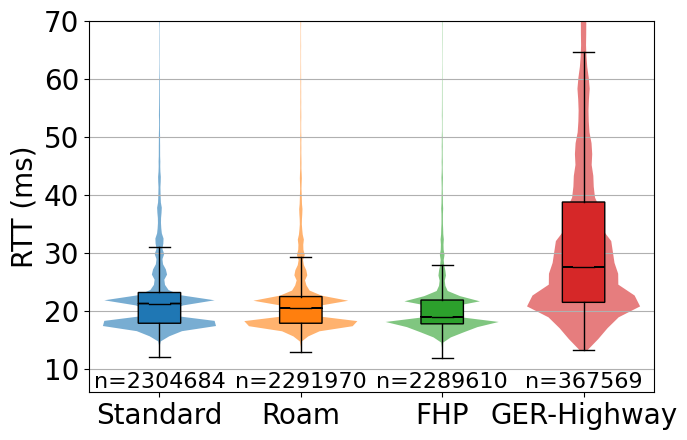

In [9]:
"""Fig 6c - RTT analysis"""
import matplotlib.pyplot as plt
autobahn_noloss = autobahn[autobahn["lost"]==False]
autobahn_noloss = autobahn_noloss[autobahn_noloss["time"]<200]
boxplot_data = [star_standard["time_ms"], star_mobile["time_ms"], star_fhp["time_ms"], autobahn_noloss["time"]]
positions = [1,2,3,4]
# Plotting
fig, ax = plt.subplots(figsize=(7, 4.5))

# Create the Violin Plots
violin_parts = ax.violinplot(boxplot_data, positions=positions, widths=0.8, showmeans=False, showmedians=False, showextrema=False)

# Set the colors for the violin plot
cmap = plt.get_cmap("tab10")
violin_colors = [cmap(i) for i in range(len(boxplot_data))]
for pc, color in zip(violin_parts['bodies'], violin_colors):
    pc.set_facecolor(color)
#    pc.set_edgecolor('black')
    pc.set_alpha(0.6)  # Adjust transparency if needed

# Create the boxplot
box = ax.boxplot(boxplot_data, positions=positions, widths=0.3, notch=True, patch_artist=True, showfliers=False)
cmap = plt.get_cmap("tab10")
colors = [cmap(0), cmap(1), cmap(2), cmap(3)]
# Set colors for each box plot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# Set median line colors to black
for median in box['medians']:
    median.set(color='black')
# Annotate number of samples above each box plot
for i, data in enumerate(boxplot_data):
    sample_size = len(data)
    ax.text(positions[i], 6, f'n={sample_size}', ha='center', va='bottom', fontsize=16, color='black')

# Create custom legend
legend_labels = ['Standard', 'Roam', 'FHP', "GER-Highway"]
legend_colors = [cmap(i) for i in range(4)]
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]
#ax.legend(handles, legend_labels, loc='upper right')

#ax.text(1, 8.5, f'n={star_standard.shape[0]}', horizontalalignment='center')
#ax.text(2, 8.5, f'n={star_mobile.shape[0]}', horizontalalignment='center')
#ax.text(3, 8.5, f'n={star_fhp.shape[0]}', horizontalalignment='center')

custom_xtick_labels = ['Standard', 'Roam', 'FHP', "GER-Highway"]
ax.set_xticklabels(custom_xtick_labels)
#plt.yscale('log')
#ax.set_yscale("log")
y_ticks = [10, 20, 30, 40, 50, 60, 70]
# Set custom y-ticks
plt.yticks(y_ticks, ["10", "20", "30", "40", "50", "60", "70"])  # Custom labels
fzsize = 20
plt.tick_params(axis='y', labelsize=fzsize)
plt.tick_params(axis='x', labelsize=fzsize)
#plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
plt.ylim(6, 70)

ax.set_ylabel('RTT (ms)', size=fzsize)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("Plots/Fig6c.pdf", format="pdf")

In [10]:
print("Standard:")
print(star_standard["time_ms"].describe())
print("----------------------------")
print("Mobile:")
print(star_mobile["time_ms"].describe())
print("----------------------------")
print("FHP:")
print(star_fhp["time_ms"].describe())
print("----------------------------")
print("GER-Highway:")
print(autobahn_noloss["time"].describe())

Standard:
count    2.304684e+06
mean     2.315315e+01
std      9.488452e+00
min      1.210000e+01
25%      1.790000e+01
50%      2.130000e+01
75%      2.320000e+01
max      9.990000e+01
Name: time_ms, dtype: float64
----------------------------
Mobile:
count    2.291970e+06
mean     2.290397e+01
std      9.645228e+00
min      1.300000e+01
25%      1.790000e+01
50%      2.050000e+01
75%      2.250000e+01
max      9.990000e+01
Name: time_ms, dtype: float64
----------------------------
FHP:
count    2.289610e+06
mean     2.194566e+01
std      9.072813e+00
min      1.190000e+01
25%      1.780000e+01
50%      1.900000e+01
75%      2.190000e+01
max      9.990000e+01
Name: time_ms, dtype: float64
----------------------------
GER-Highway:
count    367569.000000
mean         35.164095
std          22.268008
min          13.300000
25%          21.500000
50%          27.600000
75%          38.800000
max         199.000000
Name: time, dtype: float64
